# Introduction

Leukemia is a life-threatening disease. Leukemia occurs in two forms, acute or chronic. Acute leukemia develops faster than chronic leukemia and shows more intense symptoms. Acute lymphoblastic leukemia (ALL) is the most common type of cancer in childhood. While 80% of childhood leukemias are ALL, it is 20% of adult leukemias. The methods used to diagnose ALL are time-consuming and complex. In this notebook, ALL diagnosis is performed automatically using microscopic images of blood cells. Firstly, features are extracted from the images using pre-trained CNN-based deep network architectures, and then feature selection methods are used to select the relevant features from the large-size feature set obtained. Finally, machine learning algorithms are used for classification.



### 📌 Content

1. [Load and Check Data](#1)
1. [Crop Black Edges In Image](#2)
1. [Feature Extraction with VGG19, ResNet50 or ResNet101](#3)
1. [Data Scaling](#4)
1. [Feature Selection Methods](#5)
    * [ANOVA](#6)
    * [Recursive Feature Elimination (RFE)](#7)
    * [Random Forest](#8)
1. [Train / Test Split](#9)
1. [Classification with ML Algorithms](#10)
    * [kNN](#11)
    * [SVM](#12)
    * [Random Forest](#13)
    * [Naive Bayes](#14)


In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

<a id='1'></a><br>
# Load and Check Data

In [2]:
all_0 = "C:/Users/karthi/Downloads/leukemiadataset/C-NMC_Leukemia/training_data/fold_0/all"
all_1 = "C:/Users/karthi/Downloads/leukemiadataset/C-NMC_Leukemia/training_data/fold_1/all"
all_2 = "C:/Users/karthi/Downloads/leukemiadataset/C-NMC_Leukemia/training_data/fold_2/all"

hem_0 = "C:/Users/karthi/Downloads/leukemiadataset/C-NMC_Leukemia/training_data/fold_0/hem"
hem_1 = "C:/Users/karthi/Downloads/leukemiadataset/C-NMC_Leukemia/training_data/fold_1/hem"
hem_2 = "C:/Users/karthi/Downloads/leukemiadataset/C-NMC_Leukemia/training_data/fold_2/hem"

In [3]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder) 
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)
    
    return image_paths

In [4]:
img_data = []

for i in [all_0,all_1,all_2,hem_0,hem_1,hem_2]:
    paths = get_path_image(i)
    img_data.extend(paths)
print(len(img_data))

10661


In [5]:
data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data = pd.DataFrame(data) 

In [6]:
data["labels"][0:7272] = 1 # ALL
data["labels"][7272:10661] = 0 # HEM

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
data["labels"] = data["labels"].astype("int64")

<a id='2'></a><br>
# Crop Black Edges In Image

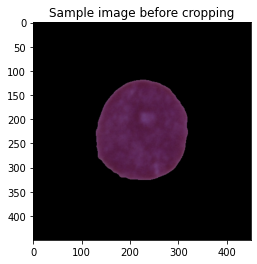

In [8]:
image = cv.imread(data["img_data"][1000])
plt.imshow(image)
plt.title("Sample image before cropping")
plt.show()

In [9]:
img_list = []
for i in range(len(img_data)):
    image = cv.imread(data["img_data"][i])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255] 
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (224,224))
    img_list.append(crop_img_r)

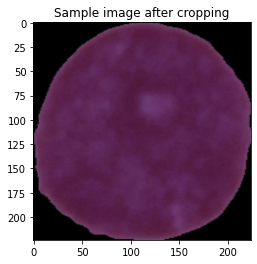

In [10]:
plt.imshow(img_list[1000])
plt.title("Sample image after cropping")
plt.show()

<a id='3'></a><br>
# Feature Extraction with VGG19, ResNet50 or ResNet101

In [11]:
from tensorflow.keras.applications import ResNet50, ResNet101
from keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input

In [12]:
def feature_extract(model):
    if model == "VGG19": model = VGG19(weights='imagenet',include_top=False, pooling="avg")
    elif model == "ResNet50": model = ResNet50(weights='imagenet',include_top=False,pooling="avg")
    elif model == "ResNet101": model = ResNet101(weights='imagenet',include_top=False,pooling="avg")
    return model

In [13]:
model = feature_extract("ResNet50") # or "VGG19", "ResNet101"

2022-07-17 11:55:53.598411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 11:55:53.696111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 11:55:53.697114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 11:55:53.699671: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [14]:
features_list = []
for i in range(len(img_list)):
            
    image = img_list[i].reshape(-1, 224, 224, 3)
    image = preprocess_input(image)
    
    """
    # Reshaping when VGG19 model is selected
    features = model.predict(image).reshape(512,)
    """

    #Reshaping  when ResNet50 or ResNet101 model is selected
    features = model.predict(image).reshape(2048,)
    
    features_list.append(features)

2022-07-17 11:55:57.860691: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-17 11:55:59.409982: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [15]:
features_df = pd.DataFrame(features_list)

In [16]:
features_df["labels"] = data["labels"]

In [17]:
x = features_df.drop(['labels'], axis = 1)
y = features_df.loc[:,"labels"].values

In [18]:
x

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,3.888962,0.003357,0.000000,0.080566,0.002496,0.003216,0.178870,0.054217,0.015593,0.044378,...,1.161144,0.046141,0.090094,0.396493,0.005848,0.000000,0.605873,0.689853,0.192492,1.315786
1,6.105570,0.000000,0.008155,0.063793,0.005606,0.047762,0.079004,0.000000,0.002628,0.012909,...,0.067440,0.000000,0.000000,0.291204,0.000000,0.000000,0.194594,0.897485,0.181279,0.888027
2,4.191668,0.000000,0.000000,0.073728,0.007410,0.040819,0.126977,0.026118,0.000000,0.000000,...,0.646455,0.000000,0.218995,0.082670,0.000000,0.000000,0.033167,0.255846,0.011669,1.841873
3,4.969845,0.190751,0.000000,0.060903,0.012210,0.034154,0.038725,0.035803,0.183819,0.000000,...,0.090973,0.018726,0.066534,0.355469,0.086317,0.053395,0.031325,0.539636,0.013693,1.445034
4,7.409761,0.000000,0.000000,0.223266,0.000000,0.013826,0.060580,0.000000,0.044893,0.025707,...,0.179018,0.005104,0.000000,0.408163,0.000000,0.000000,0.100929,0.117949,0.972515,0.484715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10656,4.650620,0.000000,0.000000,0.003782,0.000000,0.000000,0.079633,0.035964,0.052120,0.277229,...,1.089400,0.014226,0.000000,1.019125,0.584857,0.000000,0.643597,0.648635,0.098621,0.295178
10657,5.075252,0.000000,0.000000,0.073403,0.000000,0.050068,0.109488,0.000000,0.127485,0.027882,...,0.697676,0.000000,0.084636,0.057694,0.176102,0.000000,0.666509,0.455350,1.335687,0.615852
10658,5.491915,0.000000,0.000000,0.062658,0.087210,0.227873,0.310514,0.037401,0.000000,0.043394,...,0.154102,0.003430,0.000000,0.094444,0.133244,0.000000,0.083235,0.834815,0.120172,2.136769
10659,4.076107,0.017551,0.000000,0.118688,0.000000,0.000000,0.148364,0.000000,0.000000,0.000000,...,0.407700,0.026058,0.270066,0.208163,0.037542,0.000000,0.560540,0.330985,0.199827,1.003238


In [19]:
print(f"Number of features before feature selection: {x.shape[1]}")

Number of features before feature selection: 2048


In [20]:
y

array([1, 1, 1, ..., 0, 0, 0])

<a id='4'></a><br>
# Data Scaling

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x_ = scaler.transform(x)

In [22]:
x_ = pd.DataFrame(x_)

<a id='5'></a><br>
# Feature Selection Methods

<a id='6'></a><br>
## ANOVA 

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def anova_fs():
    
    selector = SelectKBest(f_classif, k=500) # k is number of features
    selector.fit(x_, y)

    cols = selector.get_support(indices=True)
    anova_x = x_[cols]
    return anova_x

<a id='7'></a><br>
## Recursive Feature Elimination (RFE)

In [24]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

def RFE_fs():
    rfe_selector = RFE(estimator=RandomForestClassifier())
    rfe_selector.fit(x_, y)
    
    rfe_support = rfe_selector.get_support()
    rfe_feature = x_.loc[:,rfe_support].columns.tolist()
    
    rfe_x = x_[rfe_feature]
    return rfe_x

<a id='8'></a><br>
## Random Forest

In [25]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def rf_fs():
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=5), threshold='1.25*median')
    embeded_rf_selector.fit(x, y)
    
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = x.loc[:,embeded_rf_support].columns.tolist()
    
    rf_x = x[embeded_rf_feature]
    return rf_x

In [26]:
fs_x = rf_fs() # feature selection methods "anova_fs", "RFE_fs"

In [27]:
print(f"Number of features after feature selection: {fs_x.shape[1]}")

Number of features after feature selection: 584


<a id='9'></a><br>
# Train Test Split

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(fs_x, y, test_size = 0.2, random_state = 42)

<a id='10'></a><br>
# Classification with ML Algorithms

In [36]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV

<a id='11'></a><br>
## kNN

In [37]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []

for i, k in enumerate(neig):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    prediction_ = knn.predict(x_test)
    train_accuracy.append(knn.score(x_train, y_train))
    test_accuracy.append(knn.score(x_test, y_test))
    
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

Best accuracy is 0.8340365682137834 with K = 17


In [38]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(x_train,y_train)
predicted = knn.predict(x_test)
score = knn.score(x_test, y_test)
knn_score_ = np.mean(score)

print('Accuracy : %.3f' % (knn_score_))

Accuracy : 0.834


In [39]:
p=precision_score(y_test, predicted) 
print('Precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('Recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('F1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted') 
print('Weighted f1-score: %.3f' % (f1_w))

Precision : 0.841
Recall : 0.933
F1-score: 0.885
Weighted f1-score: 0.827


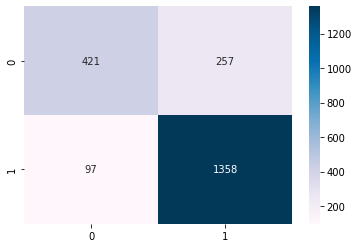

In [40]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

<a id='12'></a><br>
## SVM

In [60]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}
 
SVM_grid = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
SVM_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [61]:
print(SVM_grid.best_params_)
 
print(SVM_grid.best_estimator_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


In [62]:
svm_clf = svm.SVC(C=100, gamma=0.01, kernel='rbf')
svm_clf.fit(x_train,y_train)
predicted = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 0.900


In [63]:
p=precision_score(y_test, predicted) 
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted') 
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.902
recall : 0.957
f1-score: 0.929
weighted f1-score: 0.898


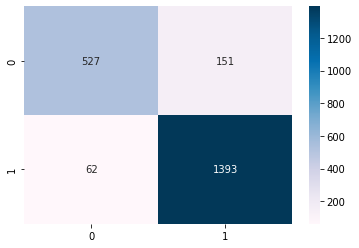

In [64]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

<a id='13'></a><br>
## Random Forest

In [52]:
param_grid_rf = { 
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8]}

RF_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv= 5)
RF_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [53]:
print(RF_grid.best_params_)

{'max_depth': 8, 'n_estimators': 500}


In [54]:
r_forest = RandomForestClassifier(500,max_depth=8, random_state=5)
r_forest.fit(x_train,y_train)
predicted = r_forest.predict(x_test)
score = r_forest.score(x_test, y_test)
rf_score_ = np.mean(score)

print('Accuracy : %.3f' % (rf_score_))

Accuracy : 0.826


In [55]:
p=precision_score(y_test, predicted) 
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted') 
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.821
recall : 0.953
f1-score: 0.882
weighted f1-score: 0.814


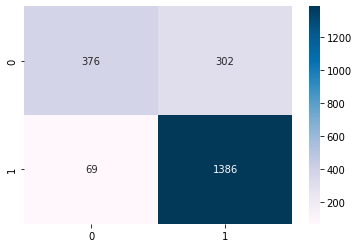

In [56]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()

<a id='14'></a><br>
## Naive Bayes

In [57]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)
predicted = nb_model.predict(x_test)
score = nb_model.score(x_test, y_test)
nb_score_ = np.mean(score)

print('Accuracy : %.3f' % (nb_score_))

Accuracy : 0.767


In [58]:
p=precision_score(y_test, predicted) 
print('precision : %.3f' % (p))

r=recall_score(y_test, predicted) 
print('recall : %.3f' % (r))

f1=f1_score(y_test, predicted) 
print('f1-score: %.3f' % (f1))

f1_w=f1_score(y_test, predicted, average='weighted') 
print('weighted f1-score: %.3f' % (f1_w))

precision : 0.852
recall : 0.798
f1-score: 0.824
weighted f1-score: 0.771


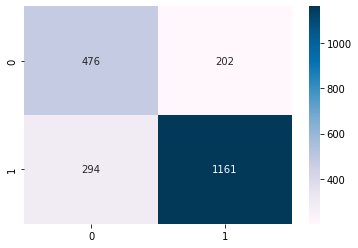

In [59]:
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
plt.show()